In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from tqdm import tqdm

import scipy.special

import delfi.distribution as dd
import delfi.generator as dg
import delfi.inference as infer
import delfi.utils.io as io
import delfi.summarystats as ds

from delfi.simulator.Gauss import Gauss

In [2]:
params = {'figure.titlesize': 'xx-large' }
pylab.rcParams.update(params)

In [3]:
# The actual prior variance
prior_var = 1

noise_var = 0.1

# Error bars in the last figure
percentile = 0.05

use_marcels_colorscheme = True

seed = 420

nrounds = 5

m = Gauss(dim=1, noise_cov=noise_var, seed=seed)
p = dd.Gaussian(m=[0], S=[[prior_var]], seed=seed)
s = ds.Identity()

g = dg.Default(model=m, prior=p, summary=s)
    
# pick observed summary statistics
xobs, obs_stats = g.gen(1)
#obs_stats = s.calc([xobs])[0]

In [4]:
def sim_with_gaussian_pp(nrounds, N, alpha=0, seed=seed):
    res = infer.SNPE(g, 
                     obs=obs_stats,
                     seed=seed, 
                     pilot_samples=None,
                     convert_to_T=False,
                     svi=True,
                     prior_mixin=alpha)

    logs, tds, posteriors = res.run(n_train=N, 
                                    n_rounds=nrounds, 
                                    minibatch=100, 
                                    epochs=1000, 
                                    round_cl=3)
    
    stds = [ p.std for p in posteriors ]
    return stds

def sim_with_studentsT_pp(nrounds, N, alpha=0, seed=seed):
    res = infer.SNPE(g, 
                     obs=obs_stats,
                     seed=seed, 
                     pilot_samples=None,
                     convert_to_T=True,
                     svi=True,
                     prior_mixin=alpha)

    logs, tds, posteriors = res.run(n_train=N, 
                                    n_rounds=nrounds, 
                                    minibatch=100, 
                                    epochs=1000, 
                                    round_cl=3)
    
    stds = [ p.std for p in posteriors ]
    return stds

In [5]:
def plot_estimates(pp_name, sim_lists):
    fig, axes = plt.subplots(len(alphas), sharex=True, sharey=True, figsize = (5, len(alphas) * 3))
    fig.suptitle("Proposal prior: {}".format(pp_name))

    if type(axes) != np.ndarray:
        axes = [axes]
    for alpha, ax in zip(alphas, axes):
        for j in range(len(Nlist)):
            ylist = [ d for d in sim_lists[alpha][Nlist[j]] ]         # Plot the average estimates
            rlist = np.arange(len(ylist))
            color = None
            if use_marcels_colorscheme:
                color = [0,j / len(Nlist),0]
            ax.semilogy(rlist, ylist, label="N = {}".format(Nlist[j]), color=color)

        ax.set_title("$\\alpha={}$".format(alpha))

        ax.set_ylabel("Average estimated variance")

        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    axes[-1].set_xlabel("Rounds")
    fig.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

In [6]:
# List of sample sizes to consider
Nlist = [ 100, 300, 1000, 3000 ]

# List of prior mixin values to consider
alphas = [ 0, 0.01, 0.1 ]

dists = { "Gaussian" : sim_with_gaussian_pp }#, "Student's T" : sim_with_studentsT_pp }

# Run simulations (this takes a while)
sim_lists = { d : { alpha : { n : dists[d](nrounds, n, alpha=alpha) for n in Nlist } \
                    for alpha in alphas } \
              for d in dists }

# Estimated variance vs. proposal prior variance

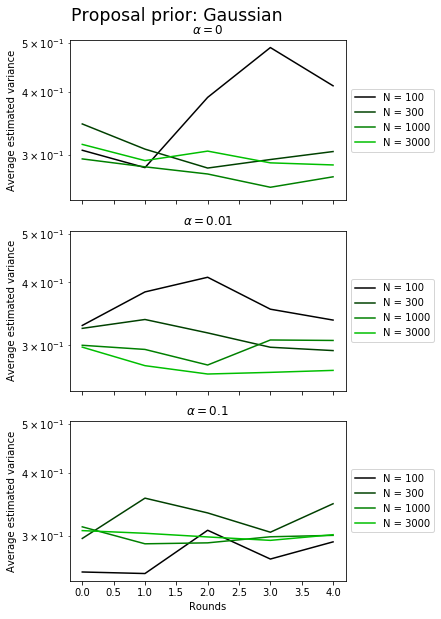

In [14]:
for d in dists:
    plot_estimates(d, sim_lists[d])